TTC Delay Predictor (Team 14) Project Source Code
Goal: Develop a machine learning regression model to predict the average subway delay (in minutes) using historical TTC subway delay data.
Scope: Analyze factors such as time of day, station location, and train line to uncover trends and improve predictions.
Source of Data: https://open.toronto.ca/dataset/ttc-subway-delay-data/

In [159]:
# Importing Necessary Libraries
# # Data Handling Libraries
import pandas as pd
import numpy as np
import os
import glob
# Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
# Feature Engineering Libraries
from datetime import datetime
# Machine Learning Models Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
# Model Evaluation Libraries
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Part 1) Data Collection, Cleaning and Exploration

In [160]:
# Data Acquisition

# GitHub Raw File URL (Updated)
url = "https://raw.githubusercontent.com/ceejay868/Team-14/main/data/combined/ttc-subway-delay-data.csv"

# Load dataset with CSV UTF-8 encoding
try:
    df = pd.read_csv(url, encoding="utf-8")
    print(f"Successfully Loaded Dataset from GitHub!")
    print(f"Dataset Shape: {df.shape}")
    print("\nFirst 5 Rows:")
    print(df.head())
except Exception as e:
    print(f"Failed to Load Dataset: {e}")

Successfully Loaded Dataset from GitHub!
Dataset Shape: (211913, 10)

First 5 Rows:
         Date  Time        Day                Station   Code  Min Delay  \
0  2014-01-01  0:21  Wednesday  VICTORIA PARK STATION  MUPR1       55.0   
1  2014-01-01  2:06  Wednesday      HIGH PARK STATION   SUDP        3.0   
2  2014-01-01  2:40  Wednesday       SHEPPARD STATION  MUNCA        0.0   
3  2014-01-01  3:10  Wednesday      LANSDOWNE STATION   SUDP        3.0   
4  2014-01-01  3:20  Wednesday          BLOOR STATION  MUSAN        5.0   

   Min Gap Bound Line  Vehicle  
0     60.0     W   BD   5111.0  
1      7.0     W   BD   5001.0  
2      0.0   NaN   YU      0.0  
3      8.0     W   BD   5116.0  
4     10.0     S   YU   5386.0  


C:\Users\ifara\AppData\Local\Temp\ipykernel_16348\2122594716.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  na_values = (df.applymap(lambda x: str(x).strip().lower() == 'n/a')).sum()  # 'n/a' strings


Missing values detected as follows:

Min Delay     1296
Min Gap       1341
Bound        56129
Line           678
Vehicle        817


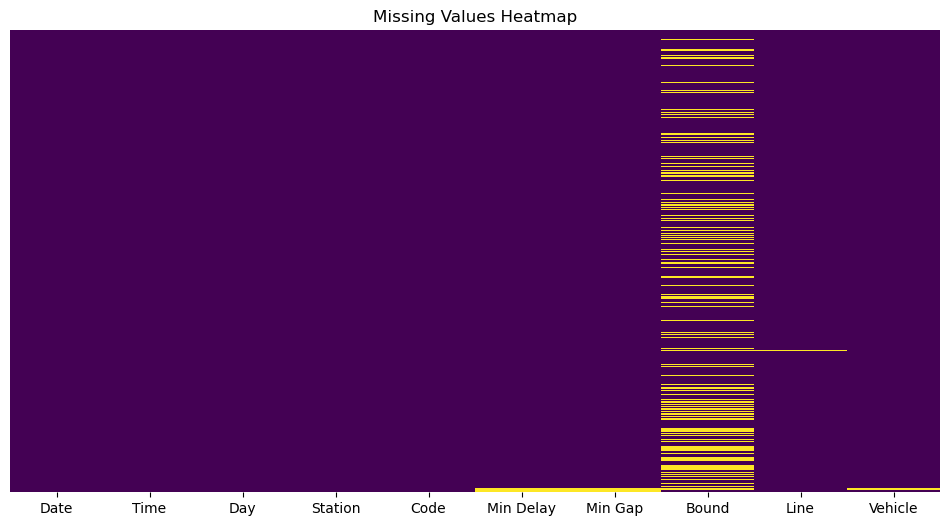

In [161]:
# Check for Missing Values

# Checking for missing values: null, empty cells, and 'n/a' strings
missing_values = df.isnull().sum()  # Standard missing values (NaN)
empty_values = (df == "").sum()  # Empty strings
na_values = (df.applymap(lambda x: str(x).strip().lower() == 'n/a')).sum()  # 'n/a' strings

# Combining all missing value checks
total_missing = missing_values + empty_values + na_values

# Displaying only columns with missing data
total_missing = total_missing[total_missing > 0]

# Printing results in a clean format
if total_missing.empty:
    print("No missing values found in the dataset!")
else:
    print("Missing values detected as follows:\n")
    print(total_missing.to_string())

# Visualizing missing values using a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cmap="viridis", cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

In [162]:
# Deal with Missing Values

# Dropping rows where the "Bound" column has missing values
df_cleaned = df.dropna()

# Displaying the shape before and after removing missing values
print(f"Original dataset shape: {df.shape}")
print(f"Dataset shape after removing rows with missing 'Bound': {df_cleaned.shape}")
print(f"Total rows removed: {df.shape[0] - df_cleaned.shape[0]}")

# Updating the dataset to use the cleaned version
df = df_cleaned

# Display the first few rows of the cleaned dataset
df.head()


Original dataset shape: (211913, 10)
Dataset shape after removing rows with missing 'Bound': (155055, 10)
Total rows removed: 56858


,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle
0,2014-01-01,0:21,Wednesday,VICTORIA PARK STATION,MUPR1,55.0,60.0,W,BD,5111.0
1,2014-01-01,2:06,Wednesday,HIGH PARK STATION,SUDP,3.0,7.0,W,BD,5001.0
3,2014-01-01,3:10,Wednesday,LANSDOWNE STATION,SUDP,3.0,8.0,W,BD,5116.0
4,2014-01-01,3:20,Wednesday,BLOOR STATION,MUSAN,5.0,10.0,S,YU,5386.0
5,2014-01-01,3:29,Wednesday,DUFFERIN STATION,MUPAA,0.0,0.0,E,BD,5174.0


C:\Users\ifara\AppData\Local\Temp\ipykernel_16348\3538717857.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  na_values = (df.applymap(lambda x: str(x).strip().lower() == 'n/a')).sum()  # 'n/a' strings


No missing values found in the dataset after cleaning


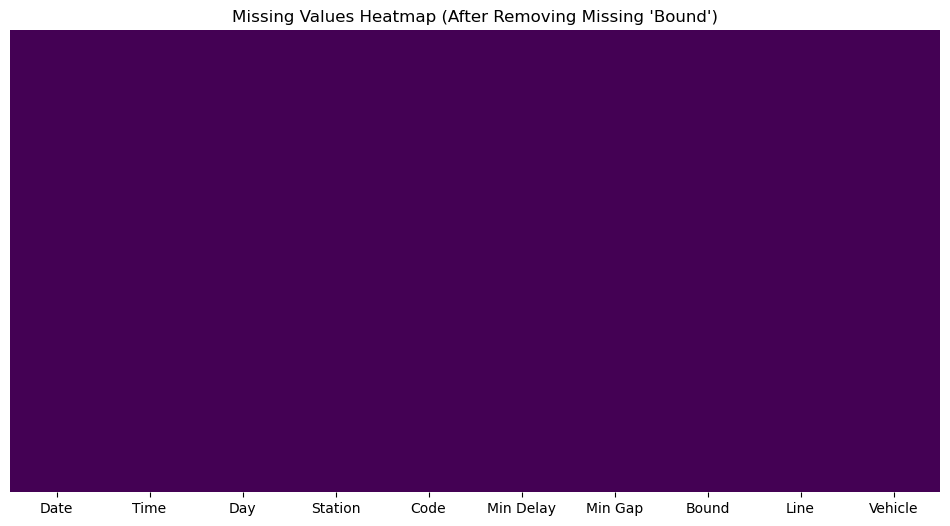

In [163]:
# Re-Check for Missing Values

# Checking for missing values: null, empty cells, and 'n/a' strings
missing_values = df.isnull().sum()  # Standard missing values (NaN)
empty_values = (df == "").sum()  # Empty strings
na_values = (df.applymap(lambda x: str(x).strip().lower() == 'n/a')).sum()  # 'n/a' strings

# Combining all missing value checks
total_missing = missing_values + empty_values + na_values

# Displaying only columns with missing data
total_missing = total_missing[total_missing > 0]

# Printing results
if total_missing.empty:
    print("No missing values found in the dataset after cleaning")
else:
    print("Missing values detected after cleaning:\n")
    print(total_missing.to_string())

# Visualizing missing values using a heatmap after cleaning
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cmap="viridis", cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap (After Removing Missing 'Bound')")
plt.show()


In [164]:
# Check for duplicate rows in the dataset
duplicate_rows = df.duplicated().sum()

# Print the number of duplicate rows
print(f"Total duplicate rows in the dataset: {duplicate_rows}")


Total duplicate rows in the dataset: 90


In [165]:
# Removing duplicate rows from the dataset
df = df.drop_duplicates()

# Printing the updated dataset shape after removing duplicates
print(f"Dataset shape after removing duplicates: {df.shape}")

df.head()

Dataset shape after removing duplicates: (154965, 10)


,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle
0,2014-01-01,0:21,Wednesday,VICTORIA PARK STATION,MUPR1,55.0,60.0,W,BD,5111.0
1,2014-01-01,2:06,Wednesday,HIGH PARK STATION,SUDP,3.0,7.0,W,BD,5001.0
3,2014-01-01,3:10,Wednesday,LANSDOWNE STATION,SUDP,3.0,8.0,W,BD,5116.0
4,2014-01-01,3:20,Wednesday,BLOOR STATION,MUSAN,5.0,10.0,S,YU,5386.0
5,2014-01-01,3:29,Wednesday,DUFFERIN STATION,MUPAA,0.0,0.0,E,BD,5174.0


In [166]:
# Re-Check for duplicate rows in the dataset
duplicate_rows = df.duplicated().sum()

# Print the number of duplicate rows
print(f"Total duplicate rows in the dataset: {duplicate_rows}")

Total duplicate rows in the dataset: 0


In [167]:
# Ensure Correct Data Types

# Converting "Date" column to datetime format
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d", errors="coerce")

# Converting "Time" column to proper time format
df["Time"] = pd.to_datetime(df["Time"], format="%H:%M", errors="coerce").dt.time

# Ensuring "Day" is a string and has valid values
df["Day"] = df["Day"].astype(str).str.strip()

# Ensuring categorical columns are strings
categorical_columns = ["Station", "Code", "Bound", "Line", "Vehicle"]
for col in categorical_columns:
    df[col] = df[col].astype(str).str.strip().str.lower()

# Ensuring "Min Delay" and "Min Gap" are numeric
df["Min Delay"] = pd.to_numeric(df["Min Delay"], errors="coerce")
df["Min Gap"] = pd.to_numeric(df["Min Gap"], errors="coerce")

# Display data types to confirm changes
print(df.dtypes)

C:\Users\ifara\AppData\Local\Temp\ipykernel_16348\3235232287.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d", errors="coerce")
C:\Users\ifara\AppData\Local\Temp\ipykernel_16348\3235232287.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Time"] = pd.to_datetime(df["Time"], format="%H:%M", errors="coerce").dt.time
C:\Users\ifara\AppData\Local\Temp\ipykernel_16348\3235232287.py:10: SettingWithCopyWarning: 
A value is trying to be set on a cop

Date         datetime64[ns]
Time                 object
Day                  object
Station              object
Code                 object
Min Delay           float64
Min Gap             float64
Bound                object
Line                 object
Vehicle              object
dtype: object


C:\Users\ifara\AppData\Local\Temp\ipykernel_16348\3235232287.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(str).str.strip().str.lower()
C:\Users\ifara\AppData\Local\Temp\ipykernel_16348\3235232287.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(str).str.strip().str.lower()
C:\Users\ifara\AppData\Local\Temp\ipykernel_16348\3235232287.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [168]:
df.head()

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle
0,2014-01-01,00:21:00,Wednesday,victoria park station,mupr1,55.0,60.0,w,bd,5111.0
1,2014-01-01,02:06:00,Wednesday,high park station,sudp,3.0,7.0,w,bd,5001.0
3,2014-01-01,03:10:00,Wednesday,lansdowne station,sudp,3.0,8.0,w,bd,5116.0
4,2014-01-01,03:20:00,Wednesday,bloor station,musan,5.0,10.0,s,yu,5386.0
5,2014-01-01,03:29:00,Wednesday,dufferin station,mupaa,0.0,0.0,e,bd,5174.0


In [169]:
# Check for Inconsistent Values

# Identify unique values in categorical columns to check for inconsistencies
for col in ["Day", "Station", "Code", "Bound", "Line"]:
    print(f"Unique values in '{col}': {df[col].unique()}")


Unique values in 'Day': ['Wednesday' 'Thursday' 'Friday' 'Saturday' 'Sunday' 'Monday' 'Tuesday']
Unique values in 'Station': ['victoria park station' 'high park station' 'lansdowne station'
 'bloor station' 'dufferin station' 'kipling station' 'yonge shp station'
 'st patrick station' 'kennedy bd station' 'jane station'
 'old mill station' 'sheppard west station' 'bay station' 'finch station'
 'coxwell station' 'st clair west station' 'north york ctr station'
 'queen station' 'dupont station' 'york mills station' 'osgoode station'
 'college station' 'yonge bd station' 'st george yus station'
 'mccowan station' 'eglinton station' 'broadview station'
 'rosedale station' 'pape station' 'greenwood station'
 'lawrence east station' 'kennedy srt station' 'islington station'
 'warden station' 'davisville station' 'lawrence station'
 'eglinton west station' 'keele station' 'midland station'
 'ellesmere station' 'union station' 'chester station' 'glencairn station'
 'wilson station' 'yorkdale s

In [170]:
# Bounds 5, R, Y, B are invalid values per TTC so we will remove them

# Storing the original dataset size before removal
original_shape = df.shape

# Defining invalid "Bound" values
invalid_bounds = ["5", "r", "y", "b"]

# Remove rows where "Bound" contains invalid values
df_cleaned = df[~df["Bound"].isin(invalid_bounds)]

# Storing the new dataset size after removal
new_shape = df_cleaned.shape

# Printing dataset size before and after removal
print(f"Original dataset shape: {original_shape}")
print(f"Dataset shape after removing invalid 'Bound' values: {new_shape}")
print(f"Total rows removed: {original_shape[0] - new_shape[0]}")

# Updating the dataset
df = df_cleaned

Original dataset shape: (154965, 10)
Dataset shape after removing invalid 'Bound' values: (154654, 10)
Total rows removed: 311


In [171]:
# The "Line" column has names that do not follow the standard of TTC and they need to be re-mapped as below:   
#(i) 'yus'	need to be re-labelled to 'yu'	
#(ii) 'line 1'	needs to be re-labelled to 'yu'
#(iii) 'bloor danforth'	needs to be re-labelled to 'bd'
#(iv) 'rt'	needs to be re-labelled to 'srt'

#Additionally, "Line" column with value of 'yu/bd' and 'yus & bd' is a combination of two subway lines and these rows should be removed

# Storing original dataset size before modifications
original_shape = df.shape

# Defining mapping for standardizing "Line" column
line_mapping = {
    "yus": "yu",
    "line 1": "yu",
    "bloor danforth": "bd",
    "rt": "srt"
}

# Applying the mapping to standardize line names
df["Line"] = df["Line"].replace(line_mapping)

# Removing rows where "Line" contains combined subway lines ('yu/bd' and 'yus & bd')
df_cleaned = df[~df["Line"].isin(["yu/bd", "yus & bd"])]

# Storing new dataset size after removal
new_shape = df_cleaned.shape

# Printing the number of rows removed
rows_removed = original_shape[0] - new_shape[0]
print(f"'Line' column is standardized per TTC.")
print(f"Removed rows where 'Line' contained combined subway lines ('yu/bd', 'yus & bd').")
print(f"Total rows removed: {rows_removed}")
print(f"Updated dataset shape: {new_shape}")

# Updating the dataset
df = df_cleaned


'Line' column is standardized per TTC.
Removed rows where 'Line' contained combined subway lines ('yu/bd', 'yus & bd').
Total rows removed: 4
Updated dataset shape: (154650, 10)


In [175]:
# Ensuring 'Station' column has correct labels
# There were a number of incorrect/unwanted values in the 'Station' column that need to be removed (not a subway station/bus station i.e., train yard)

# List of unwanted station values
unwanted_stations = [
    "mccowan station to ken", "bloor danforth subway", "sheppard line", "chester to broadview",
    "kennedy station to kip", "russell hill emergency", "finch to downsview", "eglinton to lawrence s",
    "eglinton west to bloor", "bloor to king stations", "chester to castlefrank", "lytton emergency exit",
    "bloor to york mills", "bloor to davisville", "danforth division", "finch to lawrence stat",
    "(approaching)", "moore gate", "eglinton to finch", "kipling station (enter", "union station (downsvi",
    "jane station (approach", "downsview station", "woodbine station (leav", "kennedy bd station (ap",
    "old mill station (exit", "old mill station (appr", "st george station", "dupont station (approa",
    "york mills station (ap", "islington station (app", "kennedy station (paltf", "high park station (ent",
    "wilson station (approa", "royal york station (ap", "kennedy", "mccowan station (appro", 
    "kennedy srt station (a", "dupont station (leavin", "union station (st andr", "st george bd station -",
    "wellesley station (app", "woodbine station (appr", "kipling station (leavi", "downsview station plat",
    "royal york station (le", "st clair station (appr", "york mills station (le", "union station (to st a",
    "warden station (leavin", "keele station (approac", "donlands to kipling st", "kipling station (appro",
    "sheppard station (ente", "glencairn station (app", "keele station (exiting", "rosedale station (app",
    "kipling station (platf", "coxwell station (enter", "chester station (enter", "kennedy srt station [a",
    "royal york station (en", "christie station (appr", "kennedy bd station (en", "dundas west station (a",
    "eglinton station (appr", "jane station (entering", "lawrence station (leav", "st andrew station (lea",
    "donlands station (appr", "woodbine station (exit", "mccowan station (depar", "kennedy srt station (e",
    "finch station (approac", "srt line", "line 1 yus", "line 3 scarborough srt", "bloor-danforth line",
    "greenwood wye", "zone 1", "zone 2", "line 4", "migration point", "sheppard subway line", 
    "yonge university spad", "eglinton migration", "main to victoria park", "line 3 - scarborough r",
    "viaduct", "transit control centre", "systemwide", "atc failure", "scarborough rapid tran",
    "system wide", "approaching", "sheppard west migration", "dupont migration point",
    "migration point eglint", "eglinton station migration", "tyssse line", "sheppard west to wilso",
    "union station (towards", "lawrence east to elles", "eglinton west to vmc", "midland approaching",
    "eglinton (migration)", "dupont station approac", "eglinton migration poi", "eglinton station (migr",
    "eglinton station migration", "migratio", "migration", "union station to finch", "wilson station to vmc", "e13",
    "sherbourne station (en", "sherbourne station (ap", "kennedy bd station (ex", "glenacairn station (ap",
    "ossington station (app", "islington station (ent", "finch station (exiting", "dupont station (exitin",
    "yonge station (exiting", "eglinton station (exit", "yorkdale station (exit", "finch station (leaving",
    "leaving kennedy statio", "coxwell station (leave", "entering leslie statio", "high park station (app",
    "islington station (lea", "yonge shp station (lea", "donlands station (ente", "jane station (exiting)",
    "coxwell station (exiti", "museum station (approa", "kennedy bd station (le", "keele station (enterin",
    "mccowan station (enter", "kennedy srt station (l", "museum station (leavin", "sheppard station (appr",
    "ellesmere station depa", "kipling station (exiti", "islington station (exi", "union station (approach",
    "rosedale station (appr", "christie station (leav", "union to king", "union station (enterin",
    "broadview to yonge sta", "warden station (appr", "dupont station ( appro", "chester station (leave",
    "leslie station approach", "islington station ( ap", "kennedy bd station ( a", "wilson station (exitin",
    "kipling station to ken", "tysse line", "sheppard west migrate", "union to st george",
    "warden to kennedy stat", "leaving lawrence east", "mccowan to kennedy sta", "dufferin to Lansdowne",
    "wilson to Eglinton", "king station to union", "leaving yonge/sheppard", "glencairn to st George",
    "st clair west to eglin", "st clair west to dupon", "old mill to Islington", "kipling to royal York",
    "king to union", "leslie station(approach", "union to st Andrew", "greenwood wye (enteri", "vmc to sheppard west", "union station to king", "union station to st an", "keele to dundas west",
    "welbeck emergency exit", "union to king station", "union (to st andrew)", "mcbrien building",
    "castle frank to sherbo", "lawrence to eglinton s", "finch to union station", "northbound to lawrence",
    "kipling to kennedy", "broadview to yonge", "st clair west to union", "mccowan parking lot",
    "sheppard west to downs", "yonge bd station (leav", "finch station to dupon", "union station (to king",
    "davisville to n/o bloo", "eglinton to bloor stat", "n/o davisville to n/o", "bloor via duct",
    "warden to victoria par", "wilson to st clair wes", "kipling to high park", "kipling to kennedy stn",
    "kipling to coxwell", "yorkdale to finch stat", "wilson to sheppard wes", "union to finch",
    "s/o eglinton to st cla", "queen's park to st cla", "kennedy to kipling sta", "kennedy to kipling",
    "union station to st cl", "wilson station to york", "ellis bridge", "broadview to kipling s",
    "victoria park to kenne", "union to finch station", "chester to warden", "islington to prince ed",
    "yonge to coxwell stati", "kipling to kennedy sta", "kipling to islington s", "church emergency exit",
    "w/o castle frank to gr", "chester to yonge stati", "mcbrien buiding", "bloor to st.clair",
    "vmc station to sheppar", "bloor to union", "wilson division traile", "finch to north york ct",
    "kennedy to lawrence ea", "finch to vaughan metro", "kennedy bd to kipling", "davisville to eglinton",
    "dupont to st clair wes", "museum to finch statio", "eastbound - between sh", "spadina to osgoode",
    "finch to queen station", "bloor to eglinton", "st clair to union stat", "yonge - sheppard (leav",
    "kennedy to mccowan", "coxwell to kennedy sta", "dufferin to kipling st", "keele station to kipli",
    "union station to st. a", "st clair station (leav", "leaving sheppard/yonge", "north hostler",
    "bloor viaduct", "lawrence station to yo", "royal york to islingto", "markdale ee", "leaving don mills",
    "eglinton to sheppard", "queen to finch station", "queen to king stations", "st george to bloor sta",
    "victoria park to warde", 
    "york mills to lawrence", "n/o wilson to s/o shep", "bloor danforth line", "eglinton station (ente",
    "eglinton station (leav", "greenwood portal (exit", "bloor to college", "kennedy to mccowan - l",
    "summerhill to bloor st", "kipling to islington", "leslie station (leavin", "bayview to shepaprd/yo",
    "n/o queen to markdale", "jane station to old mi", "greenwood station (app", "finch to rosedale",
    "finch west to wilson", "warden to kennedy", "pioneer village to vau", "wilson to lawrence wes",
    "kipling station to jan", "eglinton station to va", "eglinton station appro", "vmc to eglinton statio",
    "old mill to royal york", "yus line", "bayview to bessarion", "kipling to jane", "york mills (approachin",
    "midland to scarborough", "kennedy srt station to", "museum to eglinton sta", "union station towards",
    "n/b towards finch", "vmc to lawrence", "union station(toward k", "king to college",
    "college to king", "yonge station to green", "line 1 bloor to queen", "union to sheppard west",
    "dupont station to spad", "greenwood wye departin", "south bound south of l", "finch to queens park s",
    "union station (toward", "st andrew station to o", "lawrence to york mills", "ossington station(appr",
    "king station to osgood", "approching old mill st", "bloor to davisville st", "broadview to chester s",
    "union (to finch)", "union station - toward", "union station from kin", "union to wilson",
    "duncan building", "sheppard - yonge (line", "woodbine station leavi", "union to st. andrew",
    "museum station to finc", "rosedale to bloor", "st george to queens pa", "union station - finch",
    "birchmount ee", "finch to eglinton stat", "union to st. andrew st", "union station toward k",
    "midland station to ell", "eglinton station to st", "bathurst to castle fra", "jane to ossington stat",
    "leaving pape", "st. clair station (app", "wellbeck ee", "clanton portal to egli",
    "north york ctr to finc", "st andrew station to u", "king to osgoode statio", "dundas station to egli",
    "ossington to pape", "lansdowne to royal yor", "st george to pape", "union to king stations",
    "union station--st andr", "dufferin to kipling", "bathust to pape statio", "christie to pape stati",
    "christie station to pa", "dundas to finch statio", "gunn building", "chrstie to pape statio",
    "bay station to pape st", "ossington to chester", "kipling station to cox", "leslie station (approa",
    "christie station to ch", "yonge station to chest", "royal york station(app", "islington to kipling",
    "kilping station to jan", "dupont station to egli", "leaving islington", "st clair to davisville",
    "broadview and st georg", "old mill station to ja", "leslie station (enteri", "kennedy to coxwell",
    "yonge bd station to co", "st george to broadview", "sheppard to york mills", "union station - nb to",
    "union to st andrew sta", "union station to st a", "union station ( toward", "dupont to spadina",
    "kipling to old mill", "main street staiton", "e/o warden to w/o vict", "finch to union",
    "(approaching) kennedy", "high park to keele sta", "approaching dundas wes", "coxwell to kennedy",
    "islington to old mill", "eglinton to lawrence", "donlands to greenwod y", "summerhill station to",
    "jane to old mill", "wilson station approac", "finch to st clair west", "eglinton to davisville",
    "davisville to lawrence", "eglinton to union stat", "spadina to wilson stat", "finch to museum",
    "greenwood to donlands", "high park to keele", "union station to vmc", "finch station to st ge",
    "davisville - st. clair", "union to st andrew", "chester station (leavi", "leslie station aproach", 
    "wilson to eglinton", "glencairn to st george", "sheppard west migratio", "old mill to islington",
    "kipling to royal york", "leslie station(approac", "union to st andrew", "line 1 - yonge univers", 
    "coxwell station (leavi", "union station (approac"
]

# Store original dataset size before removal
original_shape = df.shape

# Remove rows where "Station" matches exactly any of the unwanted values
df_cleaned = df[~df["Station"].isin(unwanted_stations)]

# Store new dataset size after removal
new_shape = df_cleaned.shape

# Calculate number of rows removed
rows_removed = original_shape[0] - new_shape[0]

# Print number of rows removed
print(f"Total rows removed: {rows_removed}")
print(f"Original dataset shape: {original_shape}")
print(f"Updated dataset shape: {new_shape}")

# Update the dataset
df = df_cleaned


Total rows removed: 2649
Original dataset shape: (153559, 10)
Updated dataset shape: (150910, 10)


In [176]:
# Additional Station Columns Clean-up
# Station is not an actual stop and does not reperesent any valuable information. We will remove these rows

# Store original dataset size before removal
original_shape = df.shape

# Count occurrences of "station" and "stn" before removal
invalid_station_count = df["Station"].str.lower().isin(["station"]).sum()

# Print count before removal
print(f"Total occurrences of 'Station' column containing only 'station' or 'stn' before removal: {invalid_station_count}")

# Remove rows where "Station" is exactly "station" or "stn"
df_cleaned = df[~df["Station"].str.lower().isin(["station", "stn"])]

# Store new dataset size after removal
new_shape = df_cleaned.shape

# Calculate number of rows removed
rows_removed = original_shape[0] - new_shape[0]

# Print number of rows removed
print(f"Total rows removed: {rows_removed}")
print(f"Original dataset shape: {original_shape}")
print(f"Updated dataset shape: {new_shape}")

# Update the dataset
df = df_cleaned

Total occurrences of 'Station' column containing only 'station' or 'stn' before removal: 0
Total rows removed: 0
Original dataset shape: (150910, 10)
Updated dataset shape: (150910, 10)


In [177]:
# Standardizing "Station" Names

# Dictionary mapping incorrect station names to standardized names
station_mapping = {
    "st george bd station": "st george station",
    "wilson carhouse": "wilson yard",
    "greenwood carhouse": "greenwood yard",
    "kennedy bd station pla": "kennedy station",
    "osgoode": "osgoode station",
    "st clair west centre t": "st clair west station",
    "dundas station - w/s": "dundas station",
    "scarb centre station": "scarborough centre station",
    "bloor station (station": "bloor-yonge station",
    "yonge station": "bloor-yonge station",
    "dundas station e/s": "dundas station",
    "st george stn": "st george station",
    "dundas station (w/s)": "dundas station",
    "st clair west": "st clair west station",
    "vaughan mc station": "vaughan metropolitan centre station",
    "pioneer village statio": "pioneer village station",
    "bay lower": "bay station",
    "york university statio": "york university station",
    "sheppard west portal": "sheppard west station",
    "osgoode pocket": "osgoode station",
    "wilson hoslter": "wilson yard",
    "south of lawrence srt": "lawrence station",
    "kennedy - mccowan": "kennedy station",
    "bay lower station": "bay station",
    "sheppard yonge": "sheppard-yonge station",
    "york mills centre trac": "york mills station",
    "scarborough ctr statio": "scarborough centre station",
    "sheppard-yonge tail tr": "sheppard-yonge station",
    "wilson south hostler": "wilson station",
    "wilson station- hostle": "wilson station",
    "yonge university spadi": "yonge-university station",
    "wilson north hostler": "wilson station",
    "yonge sheppard satatio": "sheppard-yonge station",
    "scarborough centre sta": "scarborough centre station",
    "wilson yard - north ho": "wilson station",
    "union station (king)": "union station",
    "allen rd (n of eglinto": "allen rd n/o of eglinto",
    "spadina yus station (l": "spadina station",
    "yonge shep station": "sheppard-yonge station",
    "north york centre stat": "north york centre station",
    "greenwood complex": "greenwood station",
    "york mills center trac": "york mills station",
    "glencairn": "glencairn station",
    "king station - commerc": "king station",
    "dundas west station -": "dundas west station",
    "st calir station": "st clair station",
    "davisville buildup": "davisville station",
    "davisville build up": "davisville station",
    "davisville build-up": "davisville station",
    "davisville station - l": "davisville station",
    "sheppard/yonge station": "sheppard-yonge station",
    "queen albert": "queen station",
    "spadina station yus": "spadina station",
    "mccowan station nb": "mccowan station",
    "wilson yard north host": "wilson station",
    "spadina yu station": "spadina station",
    "kipling - kennedy": "kipling and kennedy",
    "islington centre track": "islington station",
    "sheppard- yonge statio": "sheppard-yonge station",
    "vaughan mc statio": "vaughan metropolitan centre station",
    "york mills station [": "york mills station",
    "wilson division": "wilson station",
    "st. andrew station": "st andrew station",
    "st. clair station": "st clair station",
    "mc cowan station": "mccowan station",
    "york mills centre": "york mills station",
    "st george yu station": "st george station",
    "eglinton - finch stati": "eglinton station",
    "ossington centre track": "ossington station",
    "sheppard tail track #2": "sheppard-yonge station",
    "chester centre track": "chester station",
    "st. patrick station": "st patrick station",
    "lawrence west centre": "lawrence west station",
    "eglinton station - mig": "eglinton station",
    "spadina bd staton": "spadina station",
    "eglinton psudo station": "eglinton station",
    "broadview centre track": "broadview station",
    "st. george station": "st george station",
    "sheppard-yonge and don": "sheppard-yonge station",
    "kennedy srt station la": "kennedy station",
    "main street station (e": "main street station",
    "yonge/sheppard": "sheppard-yonge station",
    "eaton centre - dundas": "dundas station",
    "eaton centre": "eaton centre station",
    "kennedy srt station -": "kennedy station",
    "christie - st george s": "christie station",
    "castle frank - broadvi": "castle frank station",
    "yonge": "yonge station",
    "union station - king": "union station",
    "union - king": "union station",
    "wilson holser": "wilson station",
    "museum ( tunnel)": "museum station",
    "osgoode station pocket": "osgoode station",
    "union station - king s": "union station",
    "bloor/yonge": "bloor-yonge station",
    "kipling station - kenn": "kipling station",
    "christie center": "christie station",
    "kennedy srt station (d": "kennedy station",
    "st. clair west": "st clair west station",
    "st george staion - le": "st george station",
    "st.george station yu": "st george station",
    "union station-king": "union station",
    "st clair staiton": "st clair station",
    "york university": "york university station",
    "n/o davisville station": "davisville station",
    "yonge and bloor statio": "bloor-yonge station",
    "yonge university subwa": "yonge-university station",
    "yonge-university and b": "yonge-university station",
    "line 1 yonge universit": "yonge-university station",
    "yonge university line": "yonge-university station",
    "line 1 yus (york mills": "york mills station",
    "kipling tail track 2": "kipling station",
    "wilson yard track 3": "wilson station",
    "bay and bloor": "bay station",
    "ramps bay lower": "bay station",
    "vaughan mc station (pl": "vaughan metropolitan centre station",
    "st clair - finch stati": "st clair station",
    "davisville station bui": "davisville station",
    "platform 2 finch": "finch station",
    "yonge sheppard station": "sheppard-yonge station",
    "bloor yu / yonge bd st": "bloor-yonge station",
    "eglinton station (sout": "eglinton station",
    "dundas station w/s": "dundas station",
    "finch west center trac": "finch west station",
    "union centre track": "union station",
    "wilson yard hostler #2": "wilson station",
    "high park - keele stat": "keele station",
    "victoria park station-": "victoria park station",
    "wilson hostler": "wilson station",
    "keele station (crossin": "keele station",
    "finch station (platfor": "finch station",
    "kennedy platform 1": "kennedy station",
    "kennedy bd station (pl": "kennedy station",
    "sehppard station": "sheppard-yonge station",
    "keele yard": "keele station",
    "sheppard west migration": "sheppard west station",
    "yus/bd/sheppard subway": "sheppard-yonge station",
    "sheppard yonge station": "sheppard-yonge station",
    "bessarian station": "bessarion station",
    "bathusrt station": "bathurst station",
    "davisville buid-up": "davisville station",
    "bloor sation":"bloor-yonge station",
    "ossington staiton":"ossington station",
    "sheppard wye":"sheppard west station",
    "mccowan yard - 3 track":"mccowan station",
    "sheppard-yonge (tail t":"sheppard-yonge station",
    "lawerence station":"lawrence station",
    "eglinton station ( migr":"eglinton station",
    "downview park station":"downsview park station",
    "glencarin station":"glencairn station",
    "eaton centre station":"dundas station",
    "union station - st andr":"union station",
    "lytton ee":"Bathurst St and Lytton Blvd",
    "museum station st. geo":"museum station",
    "scarborough rt":"scarborough centre station",
    "lawrence":"lawrence station",
    "islinton station":"islington station",
    "vmc - st clair":"st clair station",
    "wislon station":"wilson station",
    "eglinton staion":"eglinton station",
    "buchan esb": "Sheppard Ave East and Buchan Crt",
    "davisville station - b":"davisville station",
    "bloor station - yonge":"bloor-yonge station",
    "yonge bd station (on r":"bloor-yonge station",
    "eglinton stn":"eglinton station",
    "ossington staton":"ossington station",
    "union":"union station",
    "jane & runnymede stati":"jane station",
    "between warden station":"warden station",
    "eglinton yard":"eglinton station",
    "lawrence west center t":"lawrence west station",
    "dufferin staton":"dufferin station",
    "wilson hostler 2":"wilson station",
    "wilson hostler - 2":"wilson station",
    "christie centre track":"christie station",
    "hostler 2 wilson yard":"wilson station",
    "ossington centre":"ossington station",
    "finch tail":"finch station",
    "wilson yard":"wilson station",
    "eglinton station ( mig":"eglinton station",
    "south of midland srt":"south of midland street",
    "sheppard west migrati":"sheppard west station",
    "union station - st and":"union station",
    "davisville hostler":"davisville station",
    "greenwood yard":"greenwood station",
    "greenwood portal":"greenwood station",
    "davisville yard":"davisville station",
    "mccowan yard":"mccowan station",
}

# Apply the mapping to standardize the "Station" column
df["Station"] = df["Station"].replace(station_mapping)

# Print unique values after standardization to verify
print("'Station' column has been standardized.")

'Station' column has been standardized.


In [178]:
# Get unique values from the "Station" column
unique_stations = df["Station"].unique()

# Convert to a DataFrame for easy viewing
station_df = pd.DataFrame(unique_stations, columns=["Station"])

# Print the unique station names
print("Unique station names in the dataset:")
print(station_df.to_string(index=False))

Unique station names in the dataset:
                            Station
              victoria park station
                  high park station
                  lansdowne station
                      bloor station
                   dufferin station
                    kipling station
                  yonge shp station
                 st patrick station
                 kennedy bd station
                       jane station
                   old mill station
              sheppard west station
                        bay station
                      finch station
                    coxwell station
              st clair west station
             north york ctr station
                      queen station
                     dupont station
                 york mills station
                    osgoode station
                    college station
                   yonge bd station
              st george yus station
                    mccowan station
                   eglinton

In [179]:
# Get the shape of the dataset (total rows and columns) after removal and standardization of Station Column
dataset_shape = df.shape

# Print the shape of the dataset
print(f"Total Rows: {dataset_shape[0]}")
print(f"Total Columns: {dataset_shape[1]}")

Total Rows: 150910
Total Columns: 10


After Station Column standardization, we still have a sizeable data size so we can proceed with further data analysis. 

In [180]:
# Checking Code Column for Inconsistencies
# It has "XXXXX" values which are invalid and
# need to be removed from the dataset

# Count occurrences of "XXXXX" in the "Code" column before removal
xxxxx_count = df["Code"].str.upper().eq("XXXXX").sum()

# Print the count before removal
print(f"Total occurrences of 'XXXXX' in 'Code' before removal: {xxxxx_count}")

# Store original dataset size before removal
original_shape = df.shape

# Remove rows where "Code" is exactly "XXXXX" (case insensitive)
df_cleaned = df[~df["Code"].str.upper().eq("XXXXX")]

# Store new dataset size after removal
new_shape = df_cleaned.shape

# Print the number of rows removed
rows_removed = original_shape[0] - new_shape[0]
print(f"Removed rows where 'Code' was 'XXXXX'.")
print(f"Total rows removed: {rows_removed}")
print(f"Original dataset shape: {original_shape}")
print(f"Updated dataset shape: {new_shape}")

# Update the dataset
df = df_cleaned


Total occurrences of 'XXXXX' in 'Code' before removal: 3
Removed rows where 'Code' was 'XXXXX'.
Total rows removed: 3
Original dataset shape: (150910, 10)
Updated dataset shape: (150907, 10)


In [181]:
# Re-Check for Inconsistent Values
for col in ["Day", "Station", "Code", "Bound", "Line"]:
    print(f"Unique values in '{col}': {df[col].unique()}")

Unique values in 'Day': ['Wednesday' 'Thursday' 'Friday' 'Saturday' 'Sunday' 'Monday' 'Tuesday']
Unique values in 'Station': ['victoria park station' 'high park station' 'lansdowne station'
 'bloor station' 'dufferin station' 'kipling station' 'yonge shp station'
 'st patrick station' 'kennedy bd station' 'jane station'
 'old mill station' 'sheppard west station' 'bay station' 'finch station'
 'coxwell station' 'st clair west station' 'north york ctr station'
 'queen station' 'dupont station' 'york mills station' 'osgoode station'
 'college station' 'yonge bd station' 'st george yus station'
 'mccowan station' 'eglinton station' 'broadview station'
 'rosedale station' 'pape station' 'greenwood station'
 'lawrence east station' 'kennedy srt station' 'islington station'
 'warden station' 'davisville station' 'lawrence station'
 'eglinton west station' 'keele station' 'midland station'
 'ellesmere station' 'union station' 'chester station' 'glencairn station'
 'wilson station' 'yorkdale s

In [182]:
# Cleaning up Numeric Columns (Min Delay, Min Gap) - Checking for Negative Values

# Counting negative values before removal
negative_values_before = ((df["Min Delay"] < 0) | (df["Min Gap"] < 0)).sum()

# Printing count of negative values before removal
print(f"Total negative values in numeric columns before removal: {negative_values_before}")

# No negative values so we can proceed

Total negative values in numeric columns before removal: 0


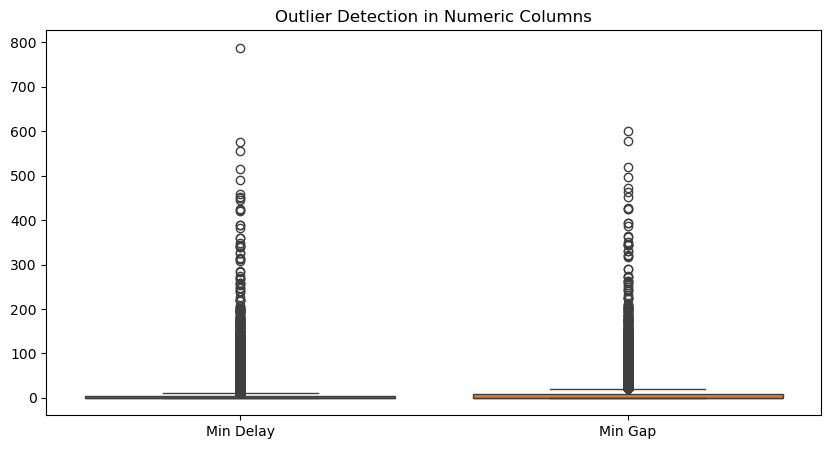

In [183]:
# Checking for outliers in Numeric Columns

# Boxplot to detect outliers
plt.figure(figsize=(10, 5))
sns.boxplot(data=df[["Min Delay", "Min Gap"]])
plt.title("Outlier Detection in Numeric Columns")
plt.show()


In [184]:
# As it can be seen from the boxplot, there are outliers in both "Min Delay" and "Min Gap" columns which can be removed

# Storing original dataset size before removing outliers
original_shape = df.shape

# Defining outlier threshold (remove top 1% extreme values)
min_delay_threshold = df["Min Delay"].quantile(0.99)
min_gap_threshold = df["Min Gap"].quantile(0.99)

# Counting outliers before removal
outliers_before = ((df["Min Delay"] > min_delay_threshold) | (df["Min Gap"] > min_gap_threshold)).sum()

# Printing count of outliers before removal
print(f"Total outliers in numeric columns before removal: {outliers_before}")

# Removing outliers (values above 99th percentile)
df_cleaned = df[(df["Min Delay"] <= min_delay_threshold) & (df["Min Gap"] <= min_gap_threshold)]

# Storing new dataset size after removal
new_shape = df_cleaned.shape

# Calculating how many outliers were removed
outliers_removed = original_shape[0] - new_shape[0]

# Print results
print(f"Removed outliers in 'Min Delay' and 'Min Gap' (above 99th percentile).")
print(f"Total outliers removed: {outliers_removed}")
print(f"Original dataset shape: {original_shape}")
print(f"Updated dataset shape: {new_shape}")

# Update the dataset
df = df_cleaned

Total outliers in numeric columns before removal: 1571
Removed outliers in 'Min Delay' and 'Min Gap' (above 99th percentile).
Total outliers removed: 1571
Original dataset shape: (150907, 10)
Updated dataset shape: (149336, 10)


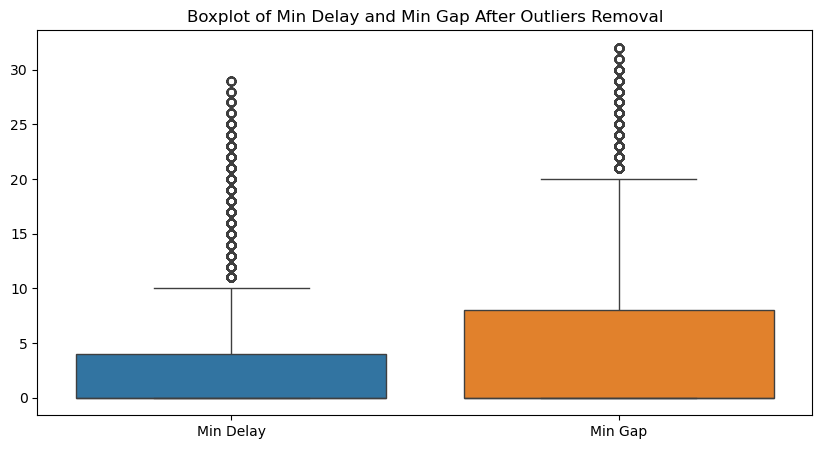

In [185]:
# Boxplot to visualize the distribution of "Min Delay" and "Min Gap" after outlier removal
plt.figure(figsize=(10, 5))
sns.boxplot(data=df[["Min Delay", "Min Gap"]])
plt.title("Boxplot of Min Delay and Min Gap After Outliers Removal")
plt.show()

In [186]:
df.head()

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle
1,2014-01-01,02:06:00,Wednesday,high park station,sudp,3.0,7.0,w,bd,5001.0
3,2014-01-01,03:10:00,Wednesday,lansdowne station,sudp,3.0,8.0,w,bd,5116.0
4,2014-01-01,03:20:00,Wednesday,bloor station,musan,5.0,10.0,s,yu,5386.0
5,2014-01-01,03:29:00,Wednesday,dufferin station,mupaa,0.0,0.0,e,bd,5174.0
12,2014-01-01,08:48:00,Wednesday,kipling station,munoa,5.0,0.0,e,bd,0.0


In [187]:
# Cleaning Date and Time Columns and Ensuring Correct Format

# Checking for missing values in "Date" and "Time"
date_missing = df["Date"].isnull().sum()
time_missing = df["Time"].isnull().sum()

# Printing the results
print(f"Missing values in 'Date': {date_missing}")
print(f"Missing values in 'Time': {time_missing}")

# No missing values in "Date" and "Time" columns so we can proceed

Missing values in 'Date': 0
Missing values in 'Time': 0


In [188]:
# Check for Invalid Dates (dataset starts from 2014 and ends at current date)

import datetime

# Define valid date range
min_valid_date = pd.Timestamp("2014-01-01")  # Start of dataset
max_valid_date = pd.Timestamp.today()        # Current date

# Count invalid dates
invalid_dates_count = df[(df["Date"] < min_valid_date) | (df["Date"] > max_valid_date)].shape[0]

# Print invalid dates count before removal
print(f"Total rows with invalid 'Date' values: {invalid_dates_count}")

# No invalid dates so we can proceed

Total rows with invalid 'Date' values: 0


Initial Descriptive Statistics

In [189]:
# Unique values in Station, Code, Bound and Line COlumns

# Count unique values in specified columns
unique_station_count = df["Station"].nunique()
unique_code_count = df["Code"].nunique()
unique_bound_count = df["Bound"].nunique()
unique_line_count = df["Line"].nunique()

# Print results
print(f"Unique 'Station' values: {unique_station_count}")
print(f"Unique 'Code' values: {unique_code_count}")
print(f"Unique 'Bound' values: {unique_bound_count}")
print(f"Unique 'Line' values: {unique_line_count}")


Unique 'Station' values: 103
Unique 'Code' values: 205
Unique 'Bound' values: 4
Unique 'Line' values: 14


In [190]:
# Descriptive statistics for "Min Delay" grouped by predictors

# Mean, Median, and Variance of "Min Delay" by "Time"
time_stats = df.groupby("Time")["Min Delay"].agg(["mean", "median", "var"]).reset_index()

# Mean, Median, and Variance of "Min Delay" by "Date"
date_stats = df.groupby("Date")["Min Delay"].agg(["mean", "median", "var"]).reset_index()

# Mean, Median, and Variance of "Min Delay" by "Station"
station_stats = df.groupby("Station")["Min Delay"].agg(["mean", "median", "var"]).reset_index()

# Mean, Median, and Variance of "Min Delay" by "Bound"
bound_stats = df.groupby("Bound")["Min Delay"].agg(["mean", "median", "var"]).reset_index()

# Mean, Median, and Variance of "Min Delay" by "Line"
line_stats = df.groupby("Line")["Min Delay"].agg(["mean", "median", "var"]).reset_index()

# Mean, Median, and Variance of "Min Delay" by "Code"
code_stats = df.groupby("Code")["Min Delay"].agg(["mean", "median", "var"]).reset_index()

# Displaying the results
descriptive_stats = {
    "Descriptive Stats by Time": time_stats,
    "Descriptive Stats by Date": date_stats,
    "Descriptive Stats by Station": station_stats,
    "Descriptive Stats by Bound": bound_stats,
    "Descriptive Stats by Line": line_stats,
    "Descriptive Stats by Code": code_stats
}

# Display data tables
for name, stats in descriptive_stats.items():
    print(f"\n{name}:\n")
    print(stats.head(20))  # Displaying only first 20 rows of each stats table
    print("\n" + "-"*50)



Descriptive Stats by Time:

        Time      mean  median        var
0   00:00:00  4.188406     3.0  29.919864
1   00:01:00  3.661972     3.0  20.855533
2   00:02:00  3.637255     3.0  25.877014
3   00:03:00  4.520408     3.0  24.850095
4   00:04:00  3.328947     3.0  17.290351
5   00:05:00  3.470588     3.0  19.625988
6   00:06:00  4.022472     3.0  26.272217
7   00:07:00  3.518987     3.0  24.124635
8   00:08:00  3.806452     3.0  24.440393
9   00:09:00  3.357143     3.0  16.812629
10  00:10:00  3.395349     1.5  19.253625
11  00:11:00  3.434211     3.0  17.288947
12  00:12:00  2.319444     0.0  12.530321
13  00:13:00  3.791667     1.5  24.786972
14  00:14:00  2.915663     0.0  14.395239
15  00:15:00  3.075000     0.0  20.475316
16  00:16:00  3.455696     3.0  19.251217
17  00:17:00  2.736842     0.0  14.969825
18  00:18:00  3.069444     3.0  10.910603
19  00:19:00  3.810811     3.0  18.265087

--------------------------------------------------

Descriptive Stats by Date:

        

In [191]:
# Extracting year and month from "Date" for grouping
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month

# Compute descriptive statistics for "Min Delay" on a yearly basis
yearly_stats = df.groupby("Year")["Min Delay"].agg(["mean", "median", "var"]).reset_index()

# Compute descriptive statistics for "Min Delay" on a monthly basis
monthly_stats = df.groupby(["Year", "Month"])["Min Delay"].agg(["mean", "median", "var"]).reset_index()

# Print results
print("\nDescriptive Stats by Year:\n", yearly_stats)
print("\nDescriptive Stats by Month:\n", monthly_stats)



Descriptive Stats by Year:
     Year      mean  median        var
0   2014  2.119702     0.0  12.086196
1   2015  1.648928     0.0  10.884947
2   2016  1.879699     0.0  12.003031
3   2017  1.991075     0.0  11.766034
4   2018  2.387759     0.0  13.341613
5   2019  2.466420     0.0  13.768767
6   2020  3.234910     3.0  14.531124
7   2021  3.515694     3.0  18.428138
8   2022  3.840413     3.0  21.234107
9   2023  3.713550     3.0  23.217462
10  2024  3.473461     3.0  21.224617
11  2025  6.365035     5.0  19.383370

Descriptive Stats by Month:
      Year  Month      mean  median        var
0    2014      1  2.506695     0.0  12.959581
1    2014      2  2.103811     0.0   9.644706
2    2014      3  2.036437     0.0  10.129664
3    2014      4  2.230833     0.0  13.068440
4    2014      5  2.139456     0.0  13.037557
..    ...    ...       ...     ...        ...
120  2024      9  3.414786     3.0  20.566915
121  2024     10  3.641847     3.0  23.990110
122  2024     11  3.416793     3.

In [192]:
# Dividing into Rush Hour and Non-Rush Hour
# Rush Hour data frame has been saved as df_rush and non-rush hour data frame has been saved as df_non_rush

# Create a new column for cleaned time format
df["Time_STR"] = df["Time"].astype(str).str.strip()

# Extract hour safely by splitting on ":" and taking the first part
df["Hour"] = df["Time_STR"].apply(lambda x: int(x.split(":")[0]) if ":" in x and x.split(":")[0].isdigit() else None)

# Remove rows where "Hour" is missing or could not be extracted
df = df.dropna(subset=["Hour"])

# Define rush hour based on the "Day" column
def is_rush_hour(row):
    weekday_rush = (row["Hour"] >= 6 and row["Hour"] <= 9) or (row["Hour"] >= 16 and row["Hour"] <= 19)
    weekend_rush = (row["Hour"] >= 10 and row["Hour"] <= 14) or (row["Hour"] >= 17 and row["Hour"] <= 19)
    
    if row["Day"].lower() in ["monday", "tuesday", "wednesday", "thursday", "friday"]:
        return 1 if weekday_rush else 0
    elif row["Day"].lower() in ["saturday", "sunday"]:
        return 1 if weekend_rush else 0
    return 0

df["RushHour"] = df.apply(is_rush_hour, axis=1)

# Define non-rush hour (Opposite of Rush Hour)
df["NonRushHour"] = df["RushHour"].apply(lambda x: 1 if x == 0 else 0)

# Create separate dataframes for rush hour and non-rush hour
df_rush = df[df["RushHour"] == 1].copy()
df_non_rush = df[df["NonRushHour"] == 1].copy()

# Print first few rows of each dataframe to confirm
print("Rush Hour Data:")
print(df_rush.head())

print("\nNon-Rush Hour Data:")
print(df_non_rush.head())



Rush Hour Data:
         Date      Time        Day             Station   Code  Min Delay  \
12 2014-01-01  08:48:00  Wednesday     kipling station  munoa        5.0   
13 2014-01-01  08:49:00  Wednesday   yonge shp station  munoa        6.0   
14 2014-01-01  08:53:00  Wednesday  st patrick station   tusc        0.0   
15 2014-01-01  08:55:00  Wednesday   yonge shp station  munoa       12.0   
16 2014-01-01  08:58:00  Wednesday  kennedy bd station  munoa        5.0   

    Min Gap Bound Line Vehicle  Year  Month  Time_STR  Hour  RushHour  \
12      0.0     e   bd     0.0  2014      1  08:48:00     8         1   
13     12.0     e  shp  5276.0  2014      1  08:49:00     8         1   
14      0.0     s   yu  5611.0  2014      1  08:53:00     8         1   
15     18.0     e  shp  5282.0  2014      1  08:55:00     8         1   
16     10.0     w   bd     0.0  2014      1  08:58:00     8         1   

    NonRushHour  
12            0  
13            0  
14            0  
15            0 

In [193]:
# Count unique values
unique_station_count_rush = df_rush["Station"].nunique()
unique_code_count_rush = df_rush["Code"].nunique()
unique_bound_count_rush = df_rush["Bound"].nunique()
unique_line_count_rush = df_rush["Line"].nunique()

unique_station_count_non = df_non_rush["Station"].nunique()
unique_code_count_non = df_non_rush["Code"].nunique()
unique_bound_count_non = df_non_rush["Bound"].nunique()
unique_line_count_non = df_non_rush["Line"].nunique()

# Print results
print("Rush Hour Data:")
print(f"Unique 'Station' values: {unique_station_count_rush}")
print(f"Unique 'Code' values: {unique_code_count_rush}")
print(f"Unique 'Bound' values: {unique_bound_count_rush}")
print(f"Unique 'Line' values: {unique_line_count_rush}")

print("\nNon-Rush Hour Data:")
print(f"Unique 'Station' values: {unique_station_count_non}")
print(f"Unique 'Code' values: {unique_code_count_non}")
print(f"Unique 'Bound' values: {unique_bound_count_non}")
print(f"Unique 'Line' values: {unique_line_count_non}")

Rush Hour Data:
Unique 'Station' values: 97
Unique 'Code' values: 195
Unique 'Bound' values: 4
Unique 'Line' values: 5

Non-Rush Hour Data:
Unique 'Station' values: 94
Unique 'Code' values: 198
Unique 'Bound' values: 4
Unique 'Line' values: 13


In [194]:
# Descriptive statistics for "Min Delay" on rush hour data grouped by predictors
rush_station_stats = df_rush.groupby("Station")["Min Delay"].agg(["mean", "median", "var"]).reset_index()
rush_bound_stats = df_rush.groupby("Bound")["Min Delay"].agg(["mean", "median", "var"]).reset_index()
rush_line_stats = df_rush.groupby("Line")["Min Delay"].agg(["mean", "median", "var"]).reset_index()
rush_code_stats = df_rush.groupby("Code")["Min Delay"].agg(["mean", "median", "var"]).reset_index()
rush_day_stats = df_rush.groupby("Day")["Min Delay"].agg(["mean", "median", "var"]).reset_index()

# Descriptive statistics for "Min Delay" on non-rush hour data grouped by predictors
non_rush_station_stats = df_non_rush.groupby("Station")["Min Delay"].agg(["mean", "median", "var"]).reset_index()
non_rush_bound_stats = df_non_rush.groupby("Bound")["Min Delay"].agg(["mean", "median", "var"]).reset_index()
non_rush_line_stats = df_non_rush.groupby("Line")["Min Delay"].agg(["mean", "median", "var"]).reset_index()
non_rush_code_stats = df_non_rush.groupby("Code")["Min Delay"].agg(["mean", "median", "var"]).reset_index()
non_rush_day_stats = df_non_rush.groupby("Day")["Min Delay"].agg(["mean", "median", "var"]).reset_index()

# Print results for Rush Hour
print("\nDescriptive Stats for Rush Hour by Station:\n", rush_station_stats.head(10))
print("\nDescriptive Stats for Rush Hour by Bound:\n", rush_bound_stats)
print("\nDescriptive Stats for Rush Hour by Line:\n", rush_line_stats)
print("\nDescriptive Stats for Rush Hour by Code:\n", rush_code_stats.head(10))
print("\nDescriptive Stats for Rush Hour by Day:\n", rush_day_stats)

# Print results for Non-Rush Hour
print("\nDescriptive Stats for Non-Rush Hour by Station:\n", non_rush_station_stats.head(10))
print("\nDescriptive Stats for Non-Rush Hour by Bound:\n", non_rush_bound_stats)
print("\nDescriptive Stats for Non-Rush Hour by Line:\n", non_rush_line_stats)
print("\nDescriptive Stats for Non-Rush Hour by Code:\n", non_rush_code_stats.head(10))
print("\nDescriptive Stats for Non-Rush Hour by Day:\n", non_rush_day_stats)



Descriptive Stats for Rush Hour by Station:
                    Station       mean  median        var
0      169 danforth avenue   0.000000     0.0        NaN
1  allen rd n/o of eglinto  28.000000    28.0        NaN
2         bathurst station   2.890034     0.0  17.450882
3              bay station   3.622517     3.0  21.337279
4          bayview station   3.197133     0.0  21.389056
5        bessarion station   3.619318     3.0  20.157110
6            bloor station   2.115146     0.0  13.320364
7      bloor-yonge station   3.857143     3.0  21.476190
8        broadview station   3.068056     3.0  16.085765
9     castle frank station   3.412281     3.0  18.976904

Descriptive Stats for Rush Hour by Bound:
   Bound      mean  median        var
0     e  2.266511     0.0  13.979779
1     n  2.881280     0.0  17.109194
2     s  2.839250     3.0  13.731423
3     w  2.295024     0.0  14.653668

Descriptive Stats for Rush Hour by Line:
       Line      mean  median        var
0  35 jane  0.0

In [195]:
# Descriptive Statistics for "Min Delay" by Rush Hour and Non-Rush Hour (Yearly and Monthly)

# Descriptive statistics for "Min Delay" on a yearly basis for rush hour data
rush_yearly_stats = df_rush.groupby("Year")["Min Delay"].agg(["mean", "median", "var"]).reset_index()

# Descriptive statistics for "Min Delay" on a monthly basis for rush hour data
rush_monthly_stats = df_rush.groupby(["Year", "Month"])["Min Delay"].agg(["mean", "median", "var"]).reset_index()

# Descriptive statistics for "Min Delay" on a yearly basis for non-rush hour data
non_rush_yearly_stats = df_non_rush.groupby("Year")["Min Delay"].agg(["mean", "median", "var"]).reset_index()

# Descriptive statistics for "Min Delay" on a monthly basis for non-rush hour data
non_rush_monthly_stats = df_non_rush.groupby(["Year", "Month"])["Min Delay"].agg(["mean", "median", "var"]).reset_index()

# Print results for Rush Hour
print("\nDescriptive Stats for Rush Hour by Year:\n", rush_yearly_stats)
print("\nDescriptive Stats for Rush Hour by Month:\n", rush_monthly_stats.head(20))

# Print results for Non-Rush Hour
print("\nDescriptive Stats for Non-Rush Hour by Year:\n", non_rush_yearly_stats)
print("\nDescriptive Stats for Non-Rush Hour by Month:\n", non_rush_monthly_stats.head(20))



Descriptive Stats for Rush Hour by Year:
     Year      mean  median        var
0   2014  2.077762     0.0  11.601151
1   2015  1.569151     0.0  10.126545
2   2016  1.736882     0.0  10.663406
3   2017  1.825460     0.0  10.911083
4   2018  2.238728     0.0  11.477473
5   2019  2.322384     0.0  12.416769
6   2020  3.123035     3.0  13.544567
7   2021  3.427058     3.0  17.399406
8   2022  3.715086     3.0  19.947154
9   2023  3.505859     3.0  20.243646
10  2024  3.410307     3.0  19.725161
11  2025  6.493671     5.0  21.825357

Descriptive Stats for Rush Hour by Month:
     Year  Month      mean  median        var
0   2014      1  2.446927     0.0  12.985991
1   2014      2  2.028037     0.0   8.310710
2   2014      3  2.043417     0.0   9.598393
3   2014      4  2.241379     0.0  12.436706
4   2014      5  2.070946     0.0  13.118478
5   2014      6  2.115865     0.0  12.520480
6   2014      7  2.191291     0.0  12.182977
7   2014      8  1.866769     0.0  11.474554
8   2014      

In [198]:
# Summary Statistics
print("\nSummary Statistics for All Data:\n")
print(df.describe(include="all"))

print("\nSummary Statistics for Rush Hour Data:\n")
print(df_rush.describe(include="all"))

print("\nSummary Statistics for non-Rush Hour Data:\n")
print(df_non_rush.describe(include="all"))


Summary Statistics for All Data:

                                 Date      Time       Day          Station  \
count                          149336    149336    149336           149336   
unique                            NaN      1428         7              103   
top                               NaN  05:55:00  Thursday  kipling station   
freq                              NaN       261     23551             6431   
mean    2019-06-17 22:54:15.370439680       NaN       NaN              NaN   
min               2014-01-01 00:00:00       NaN       NaN              NaN   
25%               2016-05-12 00:00:00       NaN       NaN              NaN   
50%               2019-05-16 00:00:00       NaN       NaN              NaN   
75%               2022-07-02 00:00:00       NaN       NaN              NaN   
max               2025-01-31 00:00:00       NaN       NaN              NaN   
std                               NaN       NaN       NaN              NaN   

          Code      Min Dela

Part 1 Complete. 